## Equity Option Implied Volatility Analytics with Python

Python has become an increasingly important tool in the domain of quantitative and algorithmic trading and research. This extends from senior quantitative analysts pricing complex derivatives using numerical techniques all the way to the retail trader using closed form valuation methods and analysis techniques. This talk will focus on the uses of Python in discovering unobserved features of listed equity options.

The Black-Scholes option pricing formula was first published in 1973 in a paper called "The Pricing of Options and Corporate Liabilities". In that paper Fischer Black and Myron Scholes derived an equation which estimates the price of an option over time. This formula and its associated "greeks" have become ubiquitous in options trading.

In this talk, we'll demonstrate how to gather options data using the Pandas module and apply various transformations to obtain the theoretical value of the option and the associated greeks. We'll then extend the talk to discuss implied volatility and show how to use Numpy methods to compute implied volatility. We'll use the results to visualize the so-called volatility skew and term structure to help inform potential trading decisions.

## About me

In undergrad studied finance, economics and computer science. Graduate school studied quantitative finance and trading. Traded interest rate derivatives for a hedge fund in Chicago, USA, worked for JPMorgan, BP and am now APAC CIO at global agricultural trading firm.

CIO has nothing to do with technology so I code in my free time.

# What are options?

Derivative contract that conveys the buyer the right (but not obligation) to buy the underlying security in the case of a call option or sell the underlying security in the case of a put option at a given price before a given date (for American style options) or on a given date (European style options).

There are many types of options of which only a few are available for retail traders. "Exotics" exist that are generally large dollar trades (millions of US$) and traded among investment banks.

We will focus on plain vanilla, european style, equity options so we can use "simple" pricing models.

Most derivatives have a payoff at the end of the life of the contract (expiration). For a call option, the payoff can be expressed simply as:

$$max(S-k, 0)$$

While the payoff for a put option can be expressed as:

$$max(k-S, 0)$$

Where $S$ and $k$ are defined below. In this case, $k$ remains fixed during the life of a contract.

Across a range of potential $S$ values, we can form what is commonly known as the "payoff profile" for a call option at expiration.

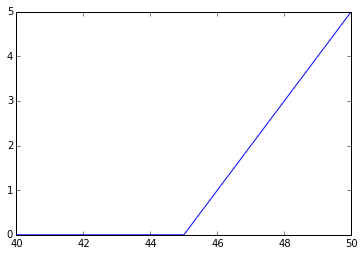

In [14]:
# magic function to plot inline
%matplotlib inline

# import numpy and pyplot
import numpy as np
import matplotlib.pyplot as plt

# create an array of fake stock prices from 40.0 to 50.0
S = np.arange(40.0, 50.0, 0.01)

# strike price
k = 45.0

# use a lambda for a payoff function
# equivelant to:
# def call_payoff(S, k):
#     return np.maximum(S - k, 0.0)
call_payoff = lambda S, k: np.maximum(S - k, 0.0)

# plot the results
plt.plot(S, call_payoff(S, k))

# Important jargon

Options priced with our simple pricing model have five variables, four of which can be observed in the market and one of which is latent (unobservable, more on this later).

* __Underlying stock price ($S$)__. Price of the underlying stock upon which the option derives its value.

* __Strike price ($k$)__. The price at which the owner of the option can buy the underlying in the case of a call or sell the underlying in the case of a put.

* __Time to expiration ($t$)__. Time (as a fraction of a 365 day year) until the expiration of the option.

* __Risk free rate ($r$)__. So-called risk free rate (this is better described as the rate of interest you would earn in a riskless security over the holding period of the option)

* __Volatility ($v$)__. Volatility (or more usually implied volatility) is a latent value not actually observed in the market.

# What is the Black-Scholes option pricing model?

Simply put, it prices a european style equity option before expiration.

### References

* http://daringfireball.net/projects/markdown/syntax
* https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model